# CARGANDO MODELOS Y DATOS


### IMPORTAR MODELOS Y DATOS

In [35]:
import joblib
import requests
import pandas as pd
import io
from huggingface_hub import hf_hub_download





###RANDOM FOREST ENTRENADO

repo_id = "Mbrozon11/IRRADIATION_FORECASTING_RandomForest"
filename = "rfr.pkl"
rfr_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Load the model
rfr = joblib.load(rfr_path)


C:\Users\Mathias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Mathias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn

In [36]:
###SARIMA ENTRENADO

repo_id = "Mbrozon11/SARIMA_IRRADIATION_FORECASTING"
filename = "sarima_model.pkl"
rfr_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Load the model
SARIMA = joblib.load(rfr_path)

In [37]:
###LSTM
# URL directa al archivo .pkl
url2 = 'https://github.com/Mbenitez11/Prediccion-de-Irradiacion/raw/refs/heads/main/results/mi_modelo_LSTM.h5'

# Descargar el archivo
response2 = requests.get(url2)

from tensorflow.keras.models import load_model
import io

# Guardar el contenido descargado en un archivo temporal y cargarlo
with open('temp_model.h5', 'wb') as f:
    f.write(response2.content)

model = load_model('temp_model.h5', compile=False)

In [38]:
import tensorflow.keras.backend as K

# Definir métricas personalizadas
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r2_score(y_true, y_pred):
    total_error = K.sum(K.square(y_true - K.mean(y_true)))
    residual_error = K.sum(K.square(y_true - y_pred))
    return 1 - (residual_error / total_error)

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error', rmse, r2_score])

In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,593 (166.38 KB)

 Trainable params: 42,529 (166.13 KB)

 Non-trainable params: 64 (256.00 B)

In [40]:
# Cargar los datos

url_X_train='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/X_train.pkl'
url_X_test='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/X_test.pkl'
url_y_train='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/y_train.pkl'
url_y_test='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/y_test.pkl'
url_X1='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/X1.pkl'
url_y1='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/y1.pkl'

response1= requests.get(url_X_train)
response2=requests.get(url_X_test)
response3=requests.get(url_y_train)
response4=requests.get(url_y_test)
response5= requests.get(url_X1)
response6=requests.get(url_y1)

X_train = joblib.load(io.BytesIO(response1.content))
X_test = joblib.load(io.BytesIO(response2.content))
y_train = joblib.load(io.BytesIO(response3.content))
y_test = joblib.load(io.BytesIO(response4.content))
X1 = joblib.load(io.BytesIO(response5.content))
y1 = joblib.load(io.BytesIO(response6.content))

In [41]:
url_X_train_LSTM='https://github.com/Mbenitez11/Prediccion-de-Irradiacion/raw/refs/heads/main/results/x_train_LSTM.pkl'
url_X_test_LSTM='https://github.com/Mbenitez11/Prediccion-de-Irradiacion/raw/refs/heads/main/results/x_test_LSTM.pkl'
url_y_train_LSTM='https://github.com/Mbenitez11/Prediccion-de-Irradiacion/raw/refs/heads/main/results/y_train_LSTM.pkl'
url_y_test_LSTM='https://github.com/Mbenitez11/Prediccion-de-Irradiacion/raw/refs/heads/main/results/y_test_LSTM.pkl'
url_df_hourly_avg='https://github.com/Mbenitez11/Prediccion-de-Irradiacion/raw/refs/heads/main/results/df_hourly_avg.pkl'


response1= requests.get(url_X_train_LSTM)
response2=requests.get(url_X_test_LSTM)
response3=requests.get(url_y_train_LSTM)
response4=requests.get(url_y_test_LSTM)
response5= requests.get(url_df_hourly_avg)


x_train_LSTM = joblib.load(io.BytesIO(response1.content))
x_test_LSTM = joblib.load(io.BytesIO(response2.content))
y_train_LSTM = joblib.load(io.BytesIO(response3.content))
y_test_LSTM = joblib.load(io.BytesIO(response4.content))
df_hourly_avg = joblib.load(io.BytesIO(response5.content))


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### LSTM PREDICCIONES

In [43]:
n_cols = 1
dataset = df_hourly_avg['IRRADIATION']
dataset = pd.DataFrame(dataset)
data = dataset.values
data.shape

(8755, 1)

In [44]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

In [45]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)
train_data = scaled_data[0:train_size, :]
time_steps = 60
train_data.shape

Train Size : 7004 Test Size : 1751


(7004, 1)

In [46]:
# Extraer las fechas correspondientes al conjunto de prueba
dates_test = df_hourly_avg.index[train_size - time_steps:]  # Desde donde comienza test_data
dates_y_test = dates_test[time_steps:]  # Ajustar por los time_steps
len(dates_y_test)

1751

In [ ]:

actual_values_in_df = df_hourly_avg.loc[dates_y_test, 'IRRADIATION']
# Revertir el escalado de y_test_LSTM a su valor original
y_test_original = scaler.inverse_transform(y_test_LSTM)

# Verificar las primeras filas
print(actual_values_in_df.head())
print(y_test_original[:5].flatten())

DATE_TIME
2017-10-19 20:00:00    0.000492
2017-10-19 21:00:00    0.000526
2017-10-19 22:00:00    0.000471
2017-10-19 23:00:00    0.000366
2017-10-20 00:00:00    0.000396
Name: IRRADIATION, dtype: float64
[0.00049158 0.00052615 0.00047098 0.00036583 0.00039634]


In [156]:
predictions = model.predict(x_test_LSTM)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [157]:
predictions.shape

(1751, 1)

In [158]:
RMSE = np.sqrt(np.mean( y_test_LSTM - predictions )**2)
RMSE

0.009930765155493947

In [159]:
preds_acts_with_dates = pd.DataFrame({
    'Date': dates_y_test,
    'Predictions': predictions.flatten(),
    'Actuals': y_test_LSTM.flatten()
})

# Establecer la fecha como índice
preds_acts_with_dates.set_index('Date', inplace=True)

# Mostrar el DataFrame
print(preds_acts_with_dates)

                     Predictions   Actuals
Date                                      
2017-10-19 20:00:00     0.001566  0.000265
2017-10-19 21:00:00    -0.002440  0.000299
2017-10-19 22:00:00    -0.004429  0.000244
2017-10-19 23:00:00    -0.005025  0.000139
2017-10-20 00:00:00    -0.004581  0.000170
...                          ...       ...
2017-12-31 14:00:00     0.009903  0.000327
2017-12-31 15:00:00     0.009901  0.000327
2017-12-31 16:00:00     0.009899  0.000327
2017-12-31 17:00:00     0.009897  0.000199
2017-12-31 18:00:00     0.009902  0.000193

[1751 rows x 2 columns]


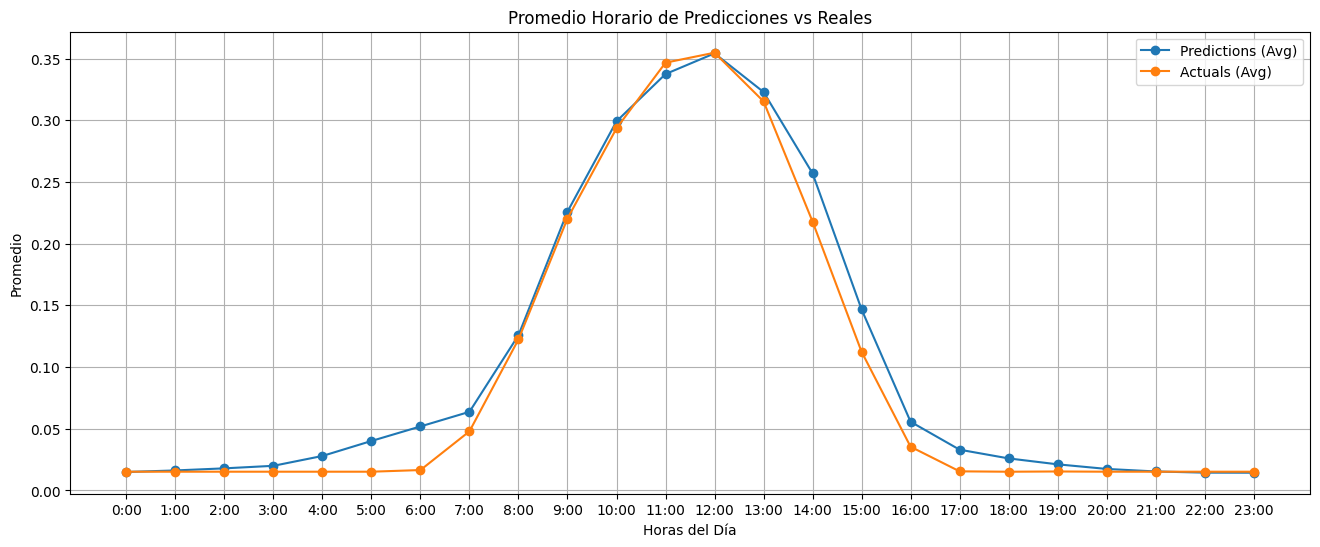

In [52]:
# Calcular promedios horarios
hourly_avg = preds_acts_with_dates.groupby(preds_acts_with_dates.index.hour).mean()

# Gráfico de promedios horarios
plt.figure(figsize=(16, 6))
hourly_avg['Predictions'].plot(label='Predictions (Avg)', marker='o')
hourly_avg['Actuals'].plot(label='Actuals (Avg)', marker='o')
plt.title('Promedio Horario de Predicciones vs Reales')
plt.xlabel('Horas del Día')
plt.ylabel('Promedio')
plt.xticks(ticks=range(0, 24), labels=[f'{i}:00' for i in range(24)])
plt.legend()
plt.grid()
plt.show()

### PREDCCIONES TRES MODELOS

In [160]:
train_size = int(len(df_hourly_avg) * 0.8)
train, test = df_hourly_avg.iloc[:train_size], df_hourly_avg.iloc[train_size:]

In [161]:
test.head()

,MODULE_TEMPERATURE,AMBIENT_TEMPERATURE,IRRADIATION,WIND_SPEED
DATE_TIME,,,,
2017-10-19 20:00:00,10.220339,16.741525,0.000492,1.894915
2017-10-19 21:00:00,9.035695,15.780847,0.000526,1.427119
2017-10-19 22:00:00,7.304254,12.728136,0.000471,0.516949
2017-10-19 23:00:00,6.728683,11.551333,0.000366,0.455000
2017-10-20 00:00:00,6.359625,11.257679,0.000396,0.419643


In [163]:
y_test_original

array([[0.00049158],
       [0.00052615],
       [0.00047098],
       ...,
       [0.000554  ],
       [0.00042633],
       [0.0004195 ]])

In [86]:
# Usar test.index para extraer el mes
drfr = test.copy()

# Asignar la estación usando el índice
def asignar_estacion(mes):
    if mes in [9, 10, 11]:  # Otoño: Sep, Oct, Nov
        return 1
    elif mes in [12, 1, 2]:  # Invierno: Dic, Ene, Feb
        return 2
    elif mes in [3, 4, 5]:  # Primavera: Mar, Abr, May
        return 3
    elif mes in [6, 7, 8]:  # Verano: Jun, Jul, Ago
        return 4

# Crear la nueva columna 'SEASON' usando el índice
drfr['SEASON'] = drfr.index.month.map(asignar_estacion)


In [87]:
drfr

,MODULE_TEMPERATURE,AMBIENT_TEMPERATURE,IRRADIATION,WIND_SPEED,SEASON
DATE_TIME,,,,,
2017-10-19 20:00:00,10.220339,16.741525,0.000492,1.894915,1
2017-10-19 21:00:00,9.035695,15.780847,0.000526,1.427119,1
2017-10-19 22:00:00,7.304254,12.728136,0.000471,0.516949,1
2017-10-19 23:00:00,6.728683,11.551333,0.000366,0.455000,1
2017-10-20 00:00:00,6.359625,11.257679,0.000396,0.419643,1
...,...,...,...,...,...
2017-12-31 14:00:00,-12.030000,-9.840000,0.000554,3.400000,2
2017-12-31 15:00:00,-12.030000,-9.840000,0.000554,3.400000,2
2017-12-31 16:00:00,-12.030000,-9.840000,0.000554,3.400000,2


In [81]:
X_test

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,SEASON
333998,21.420,27.330,0.5,1
23070,-7.025,-6.160,2.0,2
28538,6.870,4.165,8.0,2
266661,23.700,19.730,0.4,4
1283,7.937,7.928,1.2,2
...,...,...,...,...
418689,14.030,15.520,1.2,2
256131,22.370,21.110,0.3,4
434404,3.805,2.713,2.1,2
235523,28.440,35.230,3.7,4


In [ ]:
# Resetear el índice para convertir DATE_TIME en una columna
drfr = drfr.reset_index()

# Reordenar las columnas de drfr para que coincidan con las de X_test
# Eliminar las columnas 'IRRADIATION' y 'DATE_TIME' si están presentes
columns_to_keep = X_test.columns  # Las columnas en el orden deseado
drfr = drfr[columns_to_keep]





In [92]:

len(drfr)

1751

In [93]:
prediction_rfr=rfr.predict(drfr)



In [94]:
drfr.shape

(1751, 4)

In [112]:
len(prediction_rfr)

1751

In [125]:
test['IRRADIATION']
test_base=test['IRRADIATION'].reset_index()

In [127]:
test_base=test_base['IRRADIATION']

In [143]:
test_base_LSTM=[]
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]
n_cols = 1
for i in range(time_steps, len(test_data)):
    test_base_LSTM.append(test_data[i-time_steps:i, 0:n_cols])

In [169]:
y_test_LSTM

array([[0.00026472],
       [0.00029928],
       [0.00024413],
       ...,
       [0.00032712],
       [0.0001995 ],
       [0.00019267]])

In [173]:
pred_LSTM=preds_acts_with_dates['Predictions'].reset_index()

In [175]:
pred_LSTM['Predictions']

0       0.001566
1      -0.002440
2      -0.004429
3      -0.005025
4      -0.004581
          ...   
1746    0.009903
1747    0.009901
1748    0.009899
1749    0.009897
1750    0.009902
Name: Predictions, Length: 1751, dtype: float32

In [179]:
predictionsSARI = SARIMA.predict(start=test.index[0], end=test.index[-1],
                                            exog=test[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',	'WIND_SPEED']])

In [188]:
predictionsSARI.values

array([-0.03579197, -0.05255877, -0.03159507, ...,  0.00915854,
        0.00858241,  0.01265866])

### COMPARACION

In [197]:
cross_checking = pd.DataFrame({'Actual' : test_base , 'Predicted_RFR' : prediction_rfr, 'Predicted_lstm' : pred_LSTM['Predictions'], 'Predicted_SARI' : predictionsSARI.values})
cross_checking

,Actual,Predicted_RFR,Predicted_lstm,Predicted_SARI
0,0.000492,0.000556,0.001566,-0.035792
1,0.000526,0.000500,-0.002440,-0.052559
2,0.000471,0.002234,-0.004429,-0.031595
3,0.000366,0.000526,-0.005025,-0.016950
4,0.000396,0.001099,-0.004581,-0.019886
...,...,...,...,...
1746,0.000554,0.059348,0.009903,0.035213
1747,0.000554,0.059348,0.009901,0.018452
1748,0.000554,0.059348,0.009899,0.009159
1749,0.000426,0.000497,0.009897,0.008582


In [ ]:

# Crear una columna de error con las condiciones especificadas
cross_checking['Error_RFR'] = np.where(
    (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_RFR'] == 0),
    0,
    np.where(
        (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_RFR'] != 0),
        np.nan, # Reemplaza "Probablemente Apagado" con np.nan
        abs(cross_checking['Actual'] - cross_checking['Predicted_RFR']) * 100 / cross_checking['Actual']
    )
)

cross_checking['Error_lstm'] = np.where(
    (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_lstm'] == 0),
    0,
    np.where(
        (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_lstm'] != 0),
        np.nan, # Reemplaza "Probablemente Apagado" con np.nan
        abs(cross_checking['Actual'] - cross_checking['Predicted_lstm']) * 100 / cross_checking['Actual']
    )
)

cross_checking['Error_SARIMA'] = np.where(
    (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_SARI'] == 0),
    0,
    np.where(
        (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_SARI'] != 0),
        np.nan, # Reemplaza "Probablemente Apagado" con np.nan
        abs(cross_checking['Actual'] - cross_checking['Predicted_SARI']) * 100 / cross_checking['Actual']
    )
)


# Aplicar formato de estilo con un gradiente de color personalizado para resaltar errores altos en rojo
cross_checking.sample(25).style.background_gradient(
    cmap='coolwarm', subset=['Error_RFR', 'Error_lstm', 'Error_SARIMA']
).set_properties(**{
    'font-family': 'Lucida Calligraphy',
    'color': 'DarkBlack',
    'font-size': '15px'
})

,Actual,Predicted_RFR,Predicted_lstm,Predicted_SARI,Error_RFR,Error_lstm,Error_SARIMA
358,0.000513,0.004253,0.010102,0.025984,729.309325,1870.100407,4967.279450
583,0.000555,0.001094,0.002677,0.082514,97.068930,382.276569,14764.563207
795,0.000338,0.000435,-0.003962,0.020218,28.644469,1271.021206,5875.237625
302,0.222648,0.251850,0.256688,0.303261,13.115770,15.288920,36.206269
1371,0.000384,0.000403,0.003740,0.026200,5.166640,875.167675,6731.672263
332,0.041376,0.052610,0.108723,0.028280,27.151005,162.768523,31.650344
157,0.220570,0.207982,0.290641,0.215415,5.707032,31.768367,2.337156
834,0.345980,0.400634,0.395004,0.426913,15.796867,14.169563,23.392495
1070,0.430043,0.455928,0.380996,0.498421,6.019083,11.405182,15.900295
1180,0.000516,0.008806,-0.002513,0.018960,1606.544574,586.941647,3574.419075


In [199]:
X_test.head()

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,SEASON
333998,21.420,27.330,0.5,1
23070,-7.025,-6.160,2.0,2
28538,6.870,4.165,8.0,2
266661,23.700,19.730,0.4,4
1283,7.937,7.928,1.2,2


# **GRAFICAS**

Grafico de Dispersion

C:\Users\Mathias\AppData\Local\Temp\ipykernel_24608\1253664235.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([cross_checking['Actual'].min(), cross_checking['Actual'].max()],


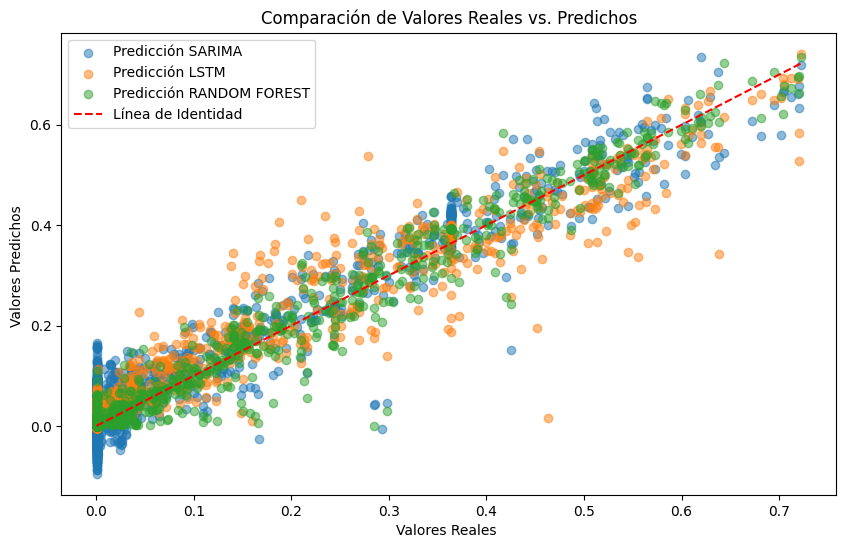

In [201]:

plt.figure(figsize=(10, 6))

plt.scatter(cross_checking['Actual'], cross_checking['Predicted_SARI'], alpha=0.5, label='Predicción SARIMA')
plt.scatter(cross_checking['Actual'], cross_checking['Predicted_lstm'], alpha=0.5, label='Predicción LSTM')
plt.scatter(cross_checking['Actual'], cross_checking['Predicted_RFR'], alpha=0.5, label='Predicción RANDOM FOREST')
plt.plot([cross_checking['Actual'].min(), cross_checking['Actual'].max()],
         [cross_checking['Actual'].min(), cross_checking['Actual'].max()],
         'k--', color='red', label='Línea de Identidad')
plt.xlabel('Valores Reales ')
plt.ylabel('Valores Predichos ')
plt.legend()
plt.title('Comparación de Valores Reales vs. Predichos')
plt.show()


Histograma de errores

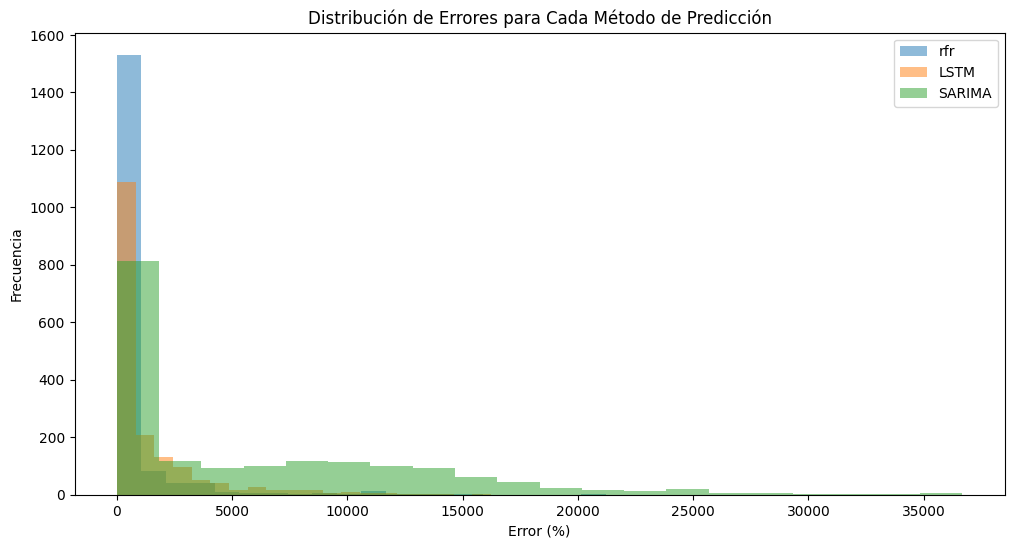

In [202]:
plt.figure(figsize=(12, 6))
plt.hist(cross_checking['Error_RFR'], bins=20, alpha=0.5, label='rfr')
plt.hist(cross_checking['Error_lstm'], bins=20, alpha=0.5, label='LSTM')
plt.hist(cross_checking['Error_SARIMA'], bins=20, alpha=0.5, label='SARIMA')


plt.xlabel('Error (%)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores para Cada Método de Predicción')
plt.legend()
plt.show()


Gráfico de Barras Comparativo

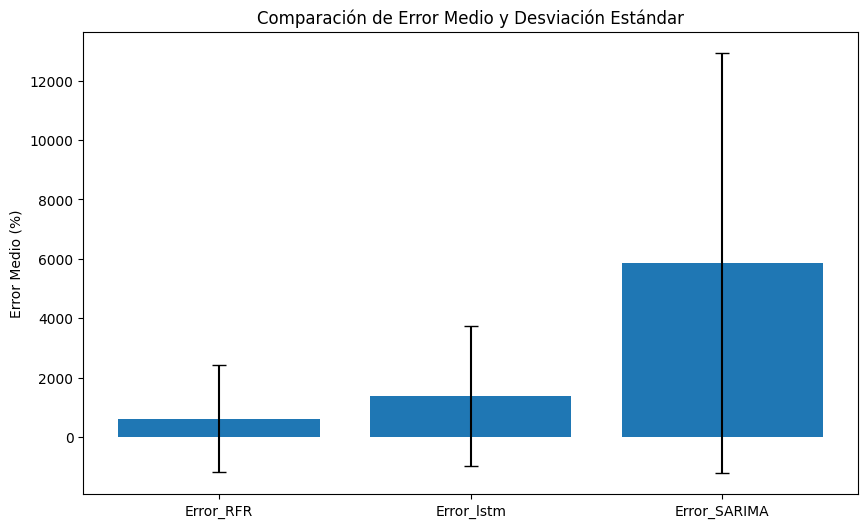

In [203]:

# Calcular la media y desviación estándar de los errores
mean_errors = [cross_checking['Error_RFR'].mean(), cross_checking['Error_lstm'].mean(), cross_checking['Error_SARIMA'].mean()]
std_errors = [cross_checking['Error_RFR'].std(), cross_checking['Error_lstm'].std(), cross_checking['Error_SARIMA'].std()]

# Crear el gráfico de barras con barras de error
plt.figure(figsize=(10, 6))
plt.bar(['Error_RFR', 'Error_lstm', 'Error_SARIMA'], mean_errors, yerr=std_errors, capsize=5)
plt.ylabel('Error Medio (%)')
plt.title('Comparación de Error Medio y Desviación Estándar')
plt.show()


Violin Plot

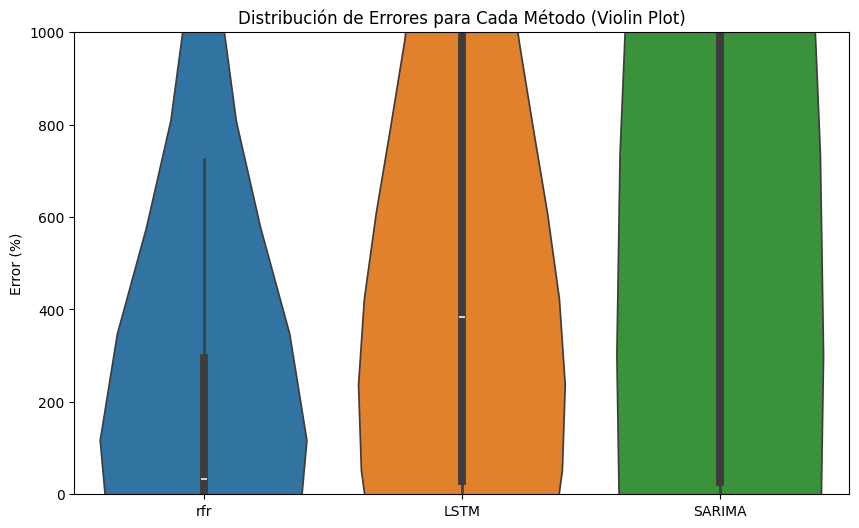

In [206]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(data=[cross_checking['Error_RFR'], cross_checking['Error_lstm'], cross_checking['Error_SARIMA']])
plt.xticks([0, 1, 2], ['rfr', 'LSTM', 'SARIMA'])
plt.ylim(0, 1000)
plt.ylabel('Error (%)')
plt.title('Distribución de Errores para Cada Método (Violin Plot)')
plt.show()


Grafico CDF

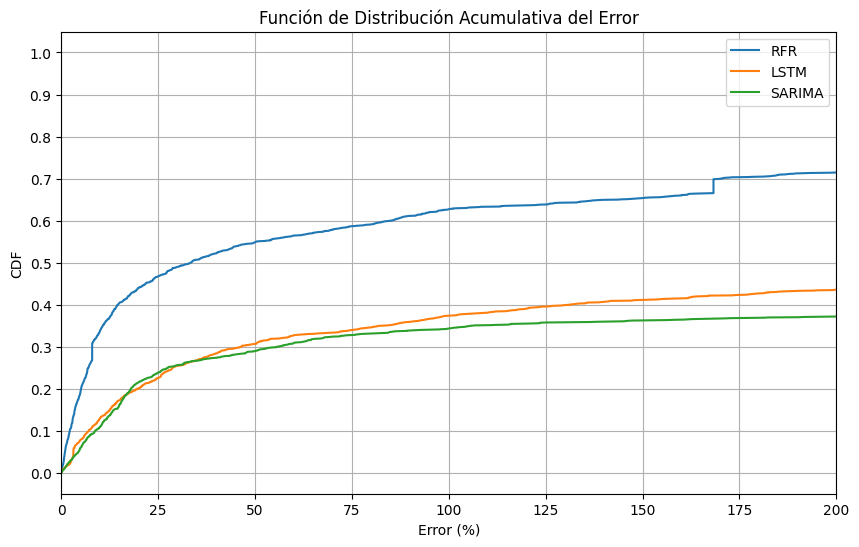

In [210]:


plt.figure(figsize=(10, 6))
for errors, label in zip([cross_checking['Error_RFR'], cross_checking['Error_lstm'], cross_checking['Error_SARIMA']],
                         ['RFR', 'LSTM', 'SARIMA']):
    sorted_errors = np.sort(errors)
    yvals = np.arange(len(sorted_errors)) / float(len(sorted_errors))
    plt.plot(sorted_errors, yvals, label=label)
plt.xlim(0, 200)
plt.xlabel('Error (%)')
plt.ylabel('CDF')
plt.title('Función de Distribución Acumulativa del Error')
plt.legend()


plt.yticks(np.arange(0, 1.1, 0.1))  # Cambia el rango y los intervalos del eje y
plt.grid(True)
plt.show()


# APLICACIONES

 1. Optimización de la operación de plantas solares:
    - Predecir la generación de energía con antelación, permitiendo una mejor gestión de la producción y distribución de energía.
   - Identificar patrones de generación y anticipar posibles fluctuaciones, optimizando el uso de recursos y evitando pérdidas.
 2. Toma de decisiones estratégicas en la inversión en energía solar:
   - Evaluar la rentabilidad de proyectos de energía solar en diferentes ubicaciones y condiciones climáticas.
    -  Aportar información crucial para inversores y desarrolladores de proyectos, minimizando riesgos y maximizando retornos.

 3.  Monitoreo y mantenimiento predictivo:
    -  Detectar anomalías en la generación de energía que podrían indicar fallas o problemas técnicos.
    -  Permitir una intervención temprana para evitar interrupciones en la producción y minimizar costos de mantenimiento.

 4. Integración con sistemas de gestión de energía:
    -  Integrar el modelo en sistemas de gestión de energía más amplios para optimizar la gestión del consumo y la generación.
    -  Facilitar la integración de la energía solar con otras fuentes de energía, mejorando la eficiencia del sistema.

 5. Análisis del impacto de variables climáticas:
    - Analizar la influencia de variables climáticas como la radiación solar, la temperatura ambiente y la temperatura del módulo en la generación de energía.
    -  Mejorar la precisión de las predicciones y adaptar las estrategias de gestión a las condiciones climáticas específicas.

 6.  Planificación de la expansión de la infraestructura solar:#    - Informar decisiones sobre la expansión de la infraestructura de generación de energía solar, considerando las predicciones de generación y las necesidades de consumo.
    -  Optimizar la ubicación y el tamaño de nuevas plantas solares para maximizar su impacto.

 7.  Estudios de impacto ambiental:
    - Evaluar el impacto ambiental de la energía solar y contribuir al desarrollo de proyectos sostenibles.
   -  Contribuir al desarrollo de modelos de gestión de energía más responsables con el medio ambiente.

 Ejemplo de uso:

 Predecir la generación de energía para las siguientes 24 horas utilizando los datos climáticos disponibles.
 Los datos deben incluir radiación solar, temperatura del módulo, y temperatura ambiente.

In [27]:
solar_data = pd.read_csv('https://raw.githubusercontent.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/refs/heads/main/data/SolarPrediction.csv')

In [28]:
solar_data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [29]:
solar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [30]:
solar_data['Data'] = pd.to_datetime(solar_data['Data'], format='%m/%d/%Y %I:%M:%S %p')

In [31]:
solar_data.isnull().sum()

,0
UNIXTime,0
Data,0
Time,0
Radiation,0
Temperature,0
Pressure,0
Humidity,0
WindDirection(Degrees),0
Speed,0
TimeSunRise,0


In [32]:
X_train.head()


,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,SEASON
189849,30.890,32.400,1.4,4
303125,20.900,16.150,1.6,1
90280,5.550,21.820,10.1,3
45688,3.481,6.894,2.4,2
430217,4.109,6.209,1.0,2


In [33]:
import random
df_solar = pd.DataFrame({'DATE_TIME' : solar_data['Data'], 'AMBIENT_TEMPERATURE' : solar_data['Temperature'], 'MODULE_TEMPERATURE' : solar_data['Temperature'],'WIND_SPEED' : solar_data['Speed'], 'SEASON' : 4})

In [34]:
df_solar.head()

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,SEASON
0,2016-09-29,48,48,5.62,4
1,2016-09-29,48,48,3.37,4
2,2016-09-29,48,48,3.37,4
3,2016-09-29,48,48,3.37,4
4,2016-09-29,48,48,5.62,4


In [35]:
prediction=rfr.predict(df_solar[['AMBIENT_TEMPERATURE',	'MODULE_TEMPERATURE','WIND_SPEED',	'SEASON']])

In [36]:
prediction

array([0.361104, 0.347072, 0.347072, ..., 0.321659, 0.321659, 0.241682])

In [37]:
df_solar['IRRADIATION']=prediction

In [38]:
df_solar.iloc[1000:1010]

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,SEASON,IRRADIATION
1000,2016-09-26,57,57,10.12,4,0.504343
1001,2016-09-26,57,57,4.50,4,0.469796
1002,2016-09-26,58,58,10.12,4,0.503785
1003,2016-09-26,58,58,9.00,4,0.503785
1004,2016-09-26,57,57,9.00,4,0.504343
1005,2016-09-26,57,57,7.87,4,0.504343
1006,2016-09-26,57,57,7.87,4,0.504343
1007,2016-09-26,57,57,7.87,4,0.504343
1008,2016-09-26,56,56,3.37,4,0.507294
1009,2016-09-26,56,56,4.50,4,0.560910


In [39]:
df_solar["DATE"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.date
df_solar["TIME"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.time
df_solar['DAY'] = pd.to_datetime(df_solar['DATE_TIME']).dt.day
df_solar['MONTH'] = pd.to_datetime(df_solar['DATE_TIME']).dt.month
df_solar['WEEK'] = pd.to_datetime(df_solar['DATE_TIME']).dt.isocalendar().week # Use isocalendar().week instead of week

# add hours and minutes for ml models
df_solar['HOURS'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.hour
df_solar['MINUTES'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.minute
df_solar['TOTAL MINUTES PASS'] = df_solar['MINUTES'] + df_solar['HOURS']*60

# add date as string column
df_solar["DATE_STRING"] = df_solar["DATE"].astype(str) # add column with date as string
df_solar["HOURS"] = df_solar["HOURS"].astype(str)
df_solar["TIME"] = df_solar["TIME"].astype(str)

df_solar.iloc[1000:1010]

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,SEASON,IRRADIATION,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,TOTAL MINUTES PASS,DATE_STRING
1000,2016-09-26,57,57,10.12,4,0.504343,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1001,2016-09-26,57,57,4.50,4,0.469796,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1002,2016-09-26,58,58,10.12,4,0.503785,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1003,2016-09-26,58,58,9.00,4,0.503785,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1004,2016-09-26,57,57,9.00,4,0.504343,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1005,2016-09-26,57,57,7.87,4,0.504343,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1006,2016-09-26,57,57,7.87,4,0.504343,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1007,2016-09-26,57,57,7.87,4,0.504343,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1008,2016-09-26,56,56,3.37,4,0.507294,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1009,2016-09-26,56,56,4.50,4,0.560910,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26


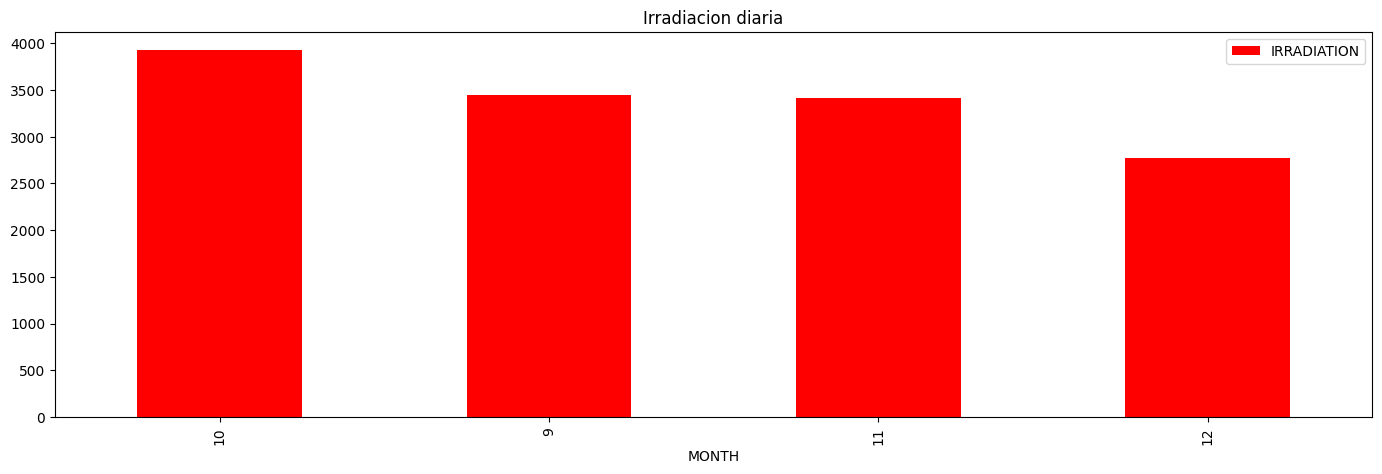

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


daily_dc = df_solar.groupby('MONTH')['IRRADIATION'].agg('sum')

ax = daily_dc.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='red')
plt.title('Irradiacion diaria')
plt.show()

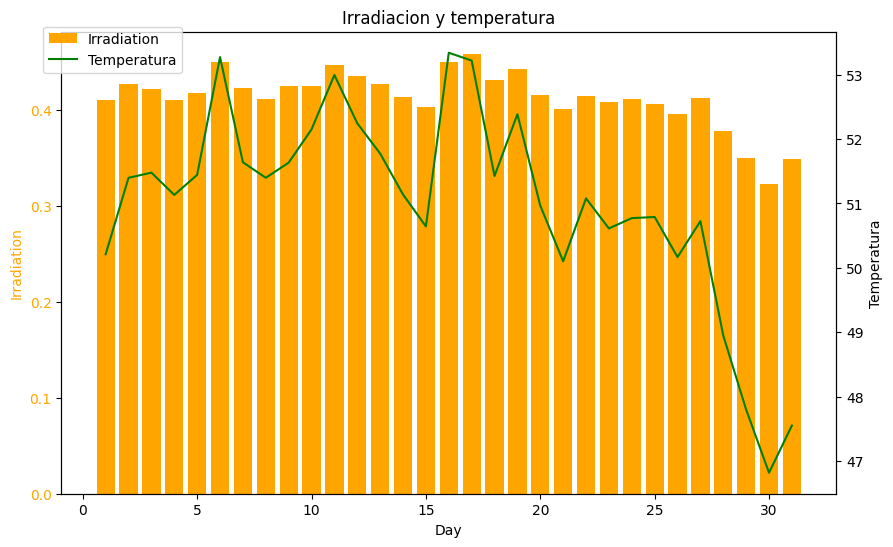

In [41]:

# Filtrar datos y crear el día de cada fecha
df_solar['Day'] = df_solar['DATE_TIME'].dt.day
irradiation = df_solar.groupby('Day')['IRRADIATION'].mean()
temperature= df_solar.groupby('Day')['AMBIENT_TEMPERATURE'].mean()
# Crear gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de Irradiation
ax1.bar(irradiation.index, irradiation.values, color='orange', label='Irradiation')
ax1.set_xlabel('Day')
ax1.set_ylabel('Irradiation', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# Crear segundo eje y graficar DC y AC Power
ax2 = ax1.twinx()
ax2.plot(temperature.index, temperature.values, color='green', label='Temperatura')
ax2.set_ylabel('Temperatura', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Agregar leyenda
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.title('Irradiacion y temperatura')
plt.show()

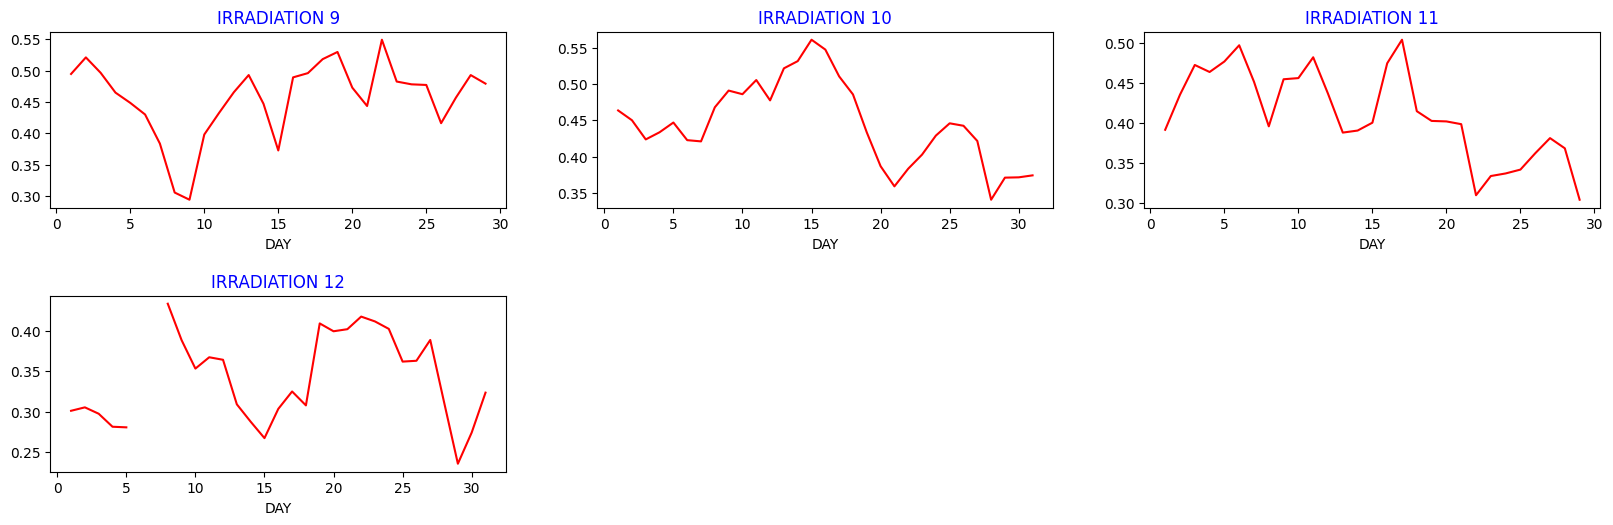

In [42]:
solar_dc = df_solar.pivot_table(values='IRRADIATION', index='DAY', columns='MONTH')

def Daywise_plot(data= None, row = None, col = None, title='IRRADIATION'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40))

    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='red')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='blue')

Daywise_plot(data=solar_dc, row=12, col=3)

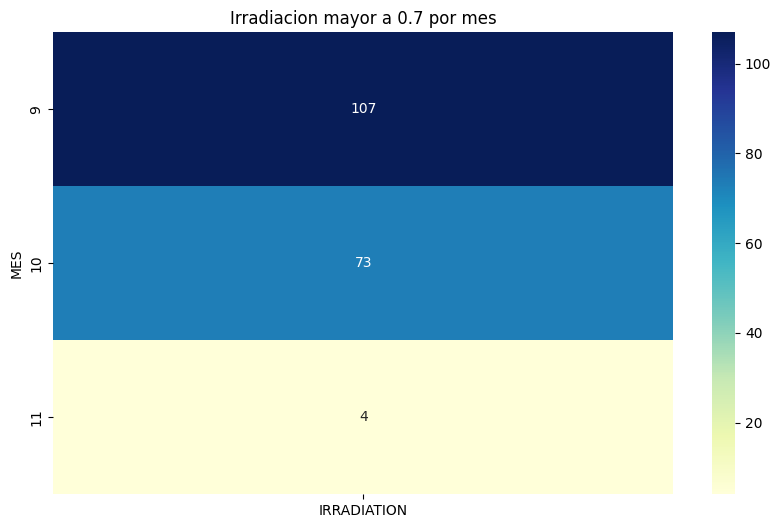

In [47]:
irradiacion_frecuencia=df_solar[df_solar['IRRADIATION'] > 0.7].groupby(df_solar['DATE_TIME' ].dt.month) [['IRRADIATION' ]].count()

plt.figure(figsize=(10, 6))
sns.heatmap(irradiacion_frecuencia, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Irradiacion mayor a 0.7 por mes')
plt.ylabel('MES')
plt.show()

CONSIDERANDO UN TRANSFORMADOR MODELO [HiKu6 Mono PERC 530 W ~ 555 W CS6W-530MS](https://static.csisolar.com/wp-content/uploads/2020/06/21135332/CS-Datasheet-HiKu6_CS6W-MS_v2.1_EN.pdf) que tiene un Isc=11.13 A




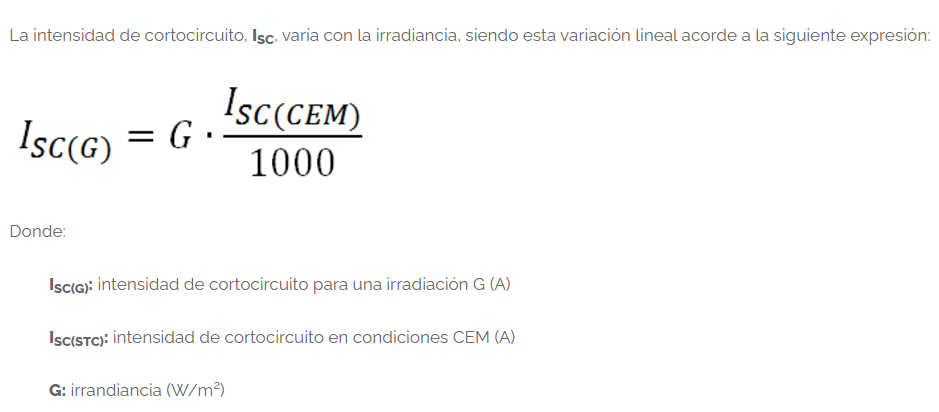



La corriente generada será:

In [43]:
df_solar['CURRENT']=df_solar['IRRADIATION']*11.13